In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import os
from collections import Counter
from matplotlib import pyplot as plt

In [2]:
event_id = 0 
hits = pd.read_csv('event00000100%d-hits.csv' % event_id )
particles = pd.read_csv('event00000100%d-particles.csv' % event_id)
truth = pd.read_csv('event00000100%d-truth.csv' % event_id)
cells = pd.read_csv('event00000100%d-cells.csv' % event_id)
detectors = pd.read_csv('detectors.csv')

In [3]:
def func_cleaning_data(cells , hits, particles , truth, pt_cut_start, pt_cut_end):
    #Finding all hit_id that is noice, to use in other files for removing nocie in them.
    def noice(truth):
        truth_hit_id_noice = [truth.hit_id[i] for i in range(len(truth)) if truth.particle_id[i] == 0]
        return truth_hit_id_noice
    truth_hit_id_noice_list = noice(truth)
    #Removing all the noice in the truth file:
    truth_zero_noice = truth.drop(truth.index[truth['particle_id'] == 0]).reset_index()
    #Removing all the data where the nhits is >=3 :
    particles_zero_noice = particles.drop(particles.index[particles['nhits'] <= 3]).reset_index()
    #Sorting the particles
    particles_zero_noice_sorted_unique = particles_zero_noice.sort_values(by = "particle_id",ascending=True)
    #Making a function that can remove all row that has a value in a list
    def FRBV(file_name, column_name, list_of_values):
        return file_name[~file_name[column_name].isin(list_of_values)]
    #Removing all the noice in the cells file:
    cells_zero_noice = FRBV(cells , "hit_id" , truth_hit_id_noice_list).reset_index()
    #Removing all the noice in the hits file:
    hits_zero_noice = FRBV(hits , "hit_id" , truth_hit_id_noice_list).reset_index()
    #Making a function that can remove all the data, that has a nhits over 7.
    def nhit_over_7(data):
        data = [data.particle_id[i] for i in range(len(data)) if data.nhits[i] > 7]
        return data
    #Removing all the data where nhits is less then 7
    particle_id_with_nhits_over_7 = nhit_over_7(particles_zero_noice_sorted_unique)
    #Removing all the data where nhits is over then 7
    particle_id_with_nhits_lees_7 = FRBV(particles_zero_noice_sorted_unique , "particle_id" , particle_id_with_nhits_over_7).drop("index",axis = 1).reset_index().drop("index",axis = 1)
    #Removing all the data where a particle_id has more then 7 nhits.
    truth_zero_noice_nhits_lees_7 = FRBV(truth_zero_noice , "particle_id" , particle_id_with_nhits_over_7).drop("index",axis = 1).reset_index().drop("index",axis = 1)
    #Making a function that can make a list of the hit_ids that has a weight of 0.
    def weight_equle_0(data):
        data = [data.hit_id[i] for i in range(len(data)) if data.weight[i] == 0]
        return data
    #Using the weight_equle_0 function to make a list of hit_id´s that has a weight equle 0
    truth_weight_0_list = weight_equle_0(truth_zero_noice_nhits_lees_7)
    #Using the list of hit_id´s that has a weight equle 0, to remove the rows in truth that has that hit_id.
    truth_zero_noice_nhits_lees_7_weight_0 = FRBV(truth_zero_noice_nhits_lees_7,"hit_id",truth_weight_0_list).reset_index().drop("index",axis = 1)
    
    #Removing the data where the particle_id has less then 7 nhits.
    truth_zero_noice_nhits_over_7 = FRBV(truth_zero_noice , "particle_id" ,truth_zero_noice_nhits_lees_7.particle_id).drop("index",axis = 1).reset_index().drop("index",axis = 1)
    #Removing the data where the hit_id has less the 7 nhits.
    hits_zero_noice_nhits_lees_7 = FRBV(hits_zero_noice, "hit_id",truth_zero_noice_nhits_over_7["hit_id"]).drop("index",axis = 1).reset_index().drop("index",axis = 1)
    #Making a list of all the particle_ids that has over 3 nhits
    particles_id_over_3 = [particles.particle_id[i] for i in range(len(particles)) if particles.nhits[i] > 3]
    #Removing all the data in truth that has less the 3 nhits. Used for later in cells and hits.  
    truth_zero_noice_over_3 = FRBV(truth_zero_noice,"particle_id",particles_id_over_3).drop("index",axis = 1).reset_index().drop("index",axis = 1)
    #Removing all the data in hits that has over the 3 nhits.
    hits_zero_noice_nhits_lees_7_over_3_with_weight_0 = FRBV(hits_zero_noice_nhits_lees_7,"hit_id",truth_zero_noice_over_3.hit_id).reset_index().drop("index",axis = 1)
    #Making a list of hit_id that is not in truth but is in hits
    hit_id_in_hits_but_not_in_truth = FRBV(hits_zero_noice_nhits_lees_7_over_3_with_weight_0,"hit_id",truth_zero_noice_nhits_lees_7_weight_0.hit_id).reset_index().drop("index",axis = 1)
    #Using that hits not in truth, and then removing them from hits. 
    hits_zero_noice_nhits_lees_7_over_3_without_weight_0 = FRBV(hits_zero_noice_nhits_lees_7_over_3_with_weight_0,"hit_id",hit_id_in_hits_but_not_in_truth.hit_id).reset_index().drop("index",axis = 1)

    #Removing the data where the hit_id has less the 7 nhits.
    cells_zero_noice_nhits_lees_7 = FRBV(cells_zero_noice, "hit_id",truth_zero_noice_nhits_over_7["hit_id"]).drop("index",axis = 1).reset_index().drop("index",axis = 1)
    #Removing all the data in cells that has over the 3 nhits.
    cells_zero_noice_nhits_lees_7_over_3_with_weight_0 = FRBV(cells_zero_noice_nhits_lees_7,"hit_id",truth_zero_noice_over_3.hit_id).reset_index().drop("index",axis = 1)
    #Making a list of hit_id that is not in truth but is in cells
    hit_id_in_cells_but_not_in_truth = FRBV(cells_zero_noice_nhits_lees_7_over_3_with_weight_0,"hit_id",truth_zero_noice_nhits_lees_7_weight_0.hit_id).reset_index().drop("index",axis = 1)
    #Using that cells hit_id not in truth, and then removing them from cells.
    cells_zero_noice_nhits_lees_7_over_3_without_weight_0 = FRBV(cells_zero_noice_nhits_lees_7_over_3_with_weight_0,"hit_id",hit_id_in_cells_but_not_in_truth.hit_id).reset_index().drop("index",axis = 1)
    
    #Putting all the data from truth into hits:
    hits_merge = hits_zero_noice_nhits_lees_7_over_3_without_weight_0.merge(truth_zero_noice_nhits_lees_7_weight_0, how='left', on='hit_id')
    #Making a same layer filter 
    def same_layer_filter(hits_new):
        hits_long_layer_filtert = hits_new.drop_duplicates(subset = ["particle_id","volume_id", "layer_id"])
        return hits_long_layer_filtert
    hits_long_layer_filtert = same_layer_filter(hits_merge)
    #Making a function that can show the removed particles from same layer filter.
    def Remove_Elements(data, thrsshold):
        counted = Counter(data)
        temp_lst = []
        for i in counted:
            if counted[i] < thrsshold:
                temp_lst.append(i)
        res_lst = []
        for i in data:
            if i not in temp_lst:
                res_lst.append(i)
        data = [i for i in data if counted[i] >= thrsshold]
        return data , temp_lst , res_lst
    thrsshold = 4
    hits_filtert , particles_nhits_less_4 , particles_nhits_over_4 = Remove_Elements(hits_long_layer_filtert["particle_id"],thrsshold)
    #Removing the particles from the same layer filter in hits_merge and particle file
    hits_merge_filtered = FRBV(hits_long_layer_filtert ,"particle_id", particles_nhits_less_4).reset_index().drop("index",axis = 1)
    particles_merge_filtered = FRBV(particle_id_with_nhits_lees_7 ,"particle_id", particles_nhits_less_4).reset_index().drop("index",axis = 1)

    #Calculating the pt of a particle:
    Pt = []
    for i in (range(len(particles_merge_filtered))):
        func = (particles_merge_filtered.px[i]**2+particles_merge_filtered.py[i]**2)**(1/2)
        Pt.append([particles_merge_filtered.particle_id[i],func])
    #Making the pt filter loop
    Pt_1GeV = []
    for i in range(len(Pt)):
        if Pt[i][1] >= pt_cut_start and Pt[i][1] <= pt_cut_end: 
            Pt_1GeV.append(Pt[i])
    #Finding the particles from the pt filter 
    particles_over_Pt_1GeV = []
    for i in range(len(Pt_1GeV)):
        particles_over_Pt_1GeV.append(Pt_1GeV[i][0])
    # Making a function that keeps values that is in list, and removes the ones that is not. 
    def FCBV(file_name, column_name, list_of_values):
        return file_name[file_name[column_name].isin(list_of_values)]
    #Removing the rows from the pt filter.  
    particles_over_Pt_1GeV_filtered = FCBV(particles_merge_filtered ,"particle_id", particles_over_Pt_1GeV).reset_index().drop("index",axis = 1)
    hits_merge_over_Pt_1GeV_filtered = FCBV(hits_merge_filtered ,"particle_id", particles_over_Pt_1GeV).reset_index().drop("index",axis = 1)
    return  hits_merge_over_Pt_1GeV_filtered , particles_over_Pt_1GeV_filtered

In [4]:
hits, particles = func_cleaning_data(cells , hits, particles , truth, 1, 3)

In [5]:
def cyl(x,y,z):
    r = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y,x)
    z = z
    return r , phi , z

r , phi , z = cyl(hits.x, hits.y, hits.z)

hits['r'] = r
hits['phi'] = phi

In [6]:
hits

,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight,r,phi
0,2274,158.3970,-39.4891,-1298.0,7,4,51,837674341054283776,158.3960,-39.4924,-1298.0,1.273990,-0.366367,-10.47030,0.000021,163.245210,-0.244324
1,3504,-54.8862,-67.8435,-1098.0,7,6,14,63050463502663680,-54.8941,-67.8461,-1098.0,-1.189830,-1.507520,-24.11860,0.000040,87.265316,-2.251008
2,3588,-76.2119,-132.1510,-1098.0,7,6,19,657533791933300736,-76.2008,-132.1590,-1098.0,-1.256010,-2.091900,-17.52120,0.000037,152.552091,-2.093910
3,4206,134.0120,-32.6236,-1098.0,7,6,51,837674341054283776,134.0160,-32.6064,-1098.0,1.279110,-0.352441,-10.47080,0.000014,137.925761,-0.238793
4,4941,-24.4873,116.0160,-1098.0,7,6,86,220677137655398400,-24.4703,116.0150,-1098.0,-0.365127,1.563800,-14.80600,0.000039,118.572088,1.778811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412,119069,-666.0430,623.9810,1502.5,18,4,86,364823799251599360,-667.7910,625.8790,1502.5,-0.797664,1.102030,2.20188,0.000021,912.669473,2.388789
413,119314,792.2870,-154.4760,1797.5,18,6,46,734119381012840448,791.2800,-154.2560,1797.5,1.254350,-0.045956,2.70021,0.000020,807.205999,-0.192559
414,119561,-776.5510,-223.5580,2147.5,18,8,6,238705280060227584,-772.1220,-222.0530,2147.5,-1.846780,-0.669826,5.24048,0.000030,808.090116,-2.861287
415,119728,960.7060,-157.4880,2152.5,18,8,47,734119381012840448,956.6580,-156.7330,2152.5,1.253830,0.001091,2.69776,0.000027,973.528884,-0.162484


In [7]:
%%time


rr = np.array(hits.r)
pp = np.array(hits.phi)


dpp = []
dpdr = []
z_0 = []
y_k = []
yeet = []
for i, idx in enumerate(range(len(pp))):
    for k, kdx in enumerate(range(len(rr))):
        dpdr = (pp[k]- pp[i])/(rr[k]-rr[i])
        z0 =  z[i] - (r[i]*(z[k]-z[i])/(r[k]-r[i]))
        if abs(dpdr) < 0.05 and abs(z0) < 249:
            y_k.append(hits.particle_id[i] == hits.particle_id[k])
            dpp.append([hits.particle_id[i] == hits.particle_id[k],dpdr, idx, kdx, hits.x[idx],hits.x[kdx]])
            z_0.append([hits.particle_id[i]== hits.particle_id[k], z0])
            yeet.append([dpdr, z0, hits.x[idx], hits.x[kdx], hits.y[idx], hits.y[kdx], hits.z[idx], hits.z[kdx]])


<timed exec>:12: RuntimeWarning: invalid value encountered in double_scalars
<timed exec>:13: RuntimeWarning: invalid value encountered in double_scalars


Wall time: 5.64 s


In [8]:
print(len(dpp), len(y_k))
print(len(yeet), len(pp))

48552 48552
48552 417


In [9]:
print(np.array(yeet).shape)

(48552, 8)


In [10]:
true_edge = []
true_z = []
for i in range(len(dpp)):
    if dpp[i][0] == True:
        true_edge.append(dpp[i])

true_edge = pd.DataFrame(true_edge)
true_edge.columns = ['Y_k' , 'dpdr', 'node_1', 'node_2', 'x1', 'x2']
true_edge = true_edge.drop_duplicates(subset = ['dpdr']).reset_index()
#true_edge['Z0'] = true_z
true_edge

,index,Y_k,dpdr,node_1,node_2,x1,x2
0,0,True,-0.000218,0,3,158.397,134.0120
1,1,True,-0.000220,0,8,158.397,116.8800
2,2,True,-0.000225,0,25,158.397,85.4547
3,3,True,-0.000216,0,39,158.397,73.1360
4,4,True,-0.000233,0,51,158.397,31.1085
...,...,...,...,...,...,...,...
856,1624,True,0.000124,394,404,816.352,1013.3800
857,1629,True,0.000194,395,410,-481.253,-628.0160
858,1636,True,0.000251,397,411,820.351,975.5410
859,1704,True,0.000181,413,415,792.287,960.7060


In [11]:
%%time
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=1,hidden_layer_sizes=(200, 50), max_iter=300)
Y = np.array(y_k)*1
X = yeet
clf.fit(X,Y)
prob = clf.predict(X)

Wall time: 34.4 s


In [12]:
print(sum(prob))

1720


In [13]:
clf.score(X, Y)

0.9962514417531718

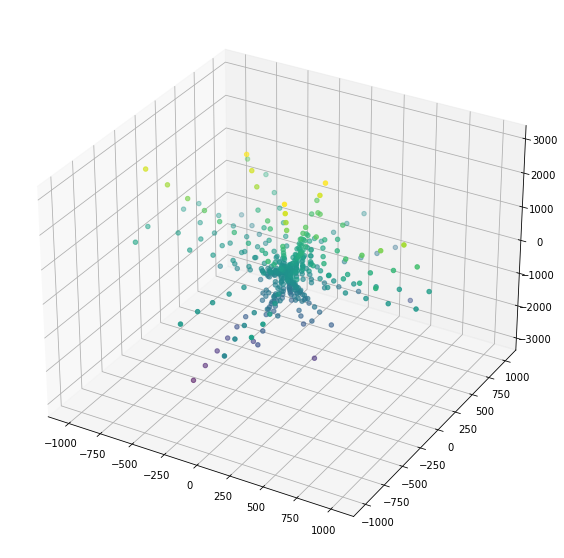

In [14]:
fig = plt.figure(1, figsize = (10,10))
ax = plt.axes(projection='3d')
ax.scatter3D(hits.x,hits.y,hits.z, c = hits.z)

In [15]:
event_id = 1 
hits1 = pd.read_csv('event00000100%d-hits.csv' % event_id )
particles1 = pd.read_csv('event00000100%d-particles.csv' % event_id)
truth1 = pd.read_csv('event00000100%d-truth.csv' % event_id)
cells1 = pd.read_csv('event00000100%d-cells.csv' % event_id)
detectors = pd.read_csv('detectors.csv')

In [16]:
hits1, particles1 = func_cleaning_data(cells1 , hits1, particles1 , truth1, 1, 3)

In [17]:
def cyl(x,y,z):
    r = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y,x)
    z = z
    return r , phi , z

r1 , phi1 , z1 = cyl(hits1.x, hits1.y, hits1.z)

hits1['r'] = r1
hits1['phi'] = phi1

In [18]:
%%time


rr1 = np.array(hits1.r)
pp1 = np.array(hits1.phi)


dpp1 = []
dpdr1 = []
z_01 = []
y_k1 = []
yeet1 = []
for i, idx in enumerate(range(len(pp1))):
    for k, kdx in enumerate(range(len(rr1))):
        dpdr = (pp[k]- pp[i])/(rr[k]-rr[i])
        z0 =  z[i] - (r[i]*(z[k]-z[i])/(r[k]-r[i]))
        if abs(dpdr) < 0.05 and abs(z0) < 249:
            y_k1.append(hits.particle_id[i] == hits.particle_id[k])
            dpp1.append([hits.particle_id[i] == hits.particle_id[k],dpdr, idx, kdx, hits.x[idx],hits.x[kdx]])
            z_01.append([hits.particle_id[i]== hits.particle_id[k], z0])
            yeet1.append([dpdr, z0, hits.x[idx], hits.x[kdx], hits.y[idx], hits.y[kdx], hits.z[idx], hits.z[kdx]])

<timed exec>:12: RuntimeWarning: invalid value encountered in double_scalars
<timed exec>:13: RuntimeWarning: invalid value encountered in double_scalars


Wall time: 1.46 s


In [19]:
X1 = np.array(yeet1)
Y1 = np.array(y_k1)
len(X1)

11644

In [20]:
prob1 = clf.predict(X1)
np.sum(prob1)


621

In [21]:
proba1 =clf.predict_proba(X1) 
proba1

array([[2.10087425e-006, 9.99997899e-001],
       [1.00000000e+000, 1.19731235e-053],
       [7.06059884e-006, 9.99992939e-001],
       ...,
       [1.00000000e+000, 5.59550557e-117],
       [1.00000000e+000, 1.32081210e-057],
       [1.00000000e+000, 1.10613053e-144]])

In [25]:
clf.score(X1, Y1)

0.9959635863964273

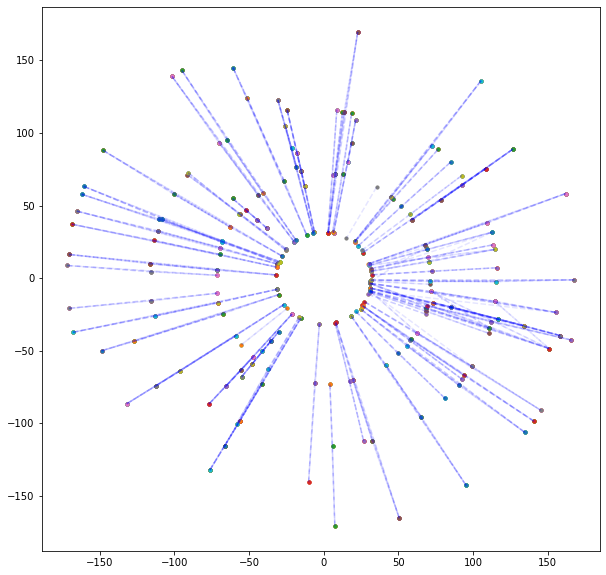

In [23]:
X_true = []
for i in range(len(prob1)):
    if prob1[i] == 1:
        X_true.append(X1[i])


edges = np.array(X_true)
xyz = edges[:,2:8]
plt.figure(69, figsize= (10,10))
for i in range(len(xyz)):
    px = np.array([xyz[i,0],xyz[i,1]])
    py = np.array([xyz[i,2], xyz[i,3]])
    plt.scatter(px,py, s = 10)
    plt.plot(px,py, '--', alpha = 0.1, color = 'b')
    #plt.xlim(35,100)
    #plt.ylim(15,80)
    

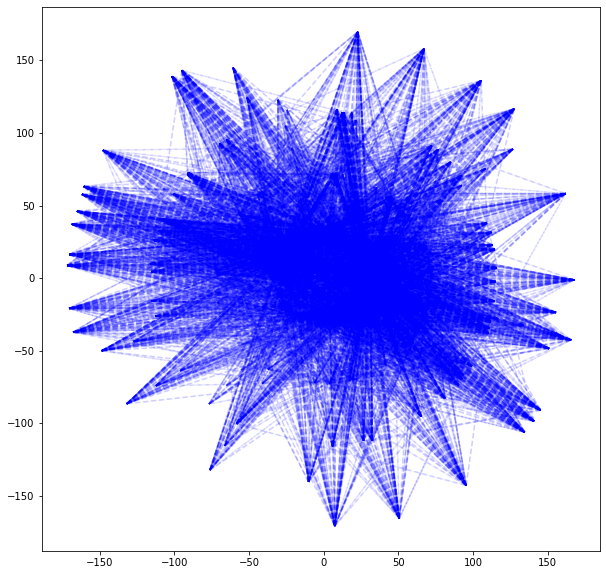

In [27]:
X_false = []
for i in range(len(prob1)):
    if prob1[i] == 0:
        X_false.append(X1[i])


n_edges = np.array(X_false)
n_xyz = n_edges[:,2:8]
plt.figure(69, figsize= (10,10))
for i in range(len(n_xyz)):
    n_px = np.array([n_xyz[i,0],n_xyz[i,1]])
    n_py = np.array([n_xyz[i,2], n_xyz[i,3]])
    #plt.scatter(n_px,n_py, s = 10)
    plt.plot(n_px,n_py, '--', alpha = 0.1, color = 'b')
    #plt.xlim(35,100)
    #plt.ylim(15,80)